In [1]:
from acquire_zillow import *
from acquire_mall import *
from prepare_mall import *
from prepare_zillow import *
import env


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# image stuff
from IPython.display import display
from PIL import Image

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2 as chi2
from sklearn.feature_selection import SelectKBest
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

from mpl_toolkits.mplot3d import Axes3D


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

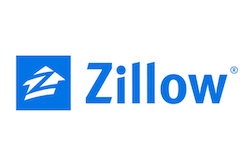

Detected zillow_data.csv - use csv (1) or gather new data (2)? 1
--- Beginning CSV Import --

--- CSV Import Complete --

Shape of DataFrame: (167854, 59)


In [2]:
df = single_units(acquire_zillow())

In [3]:
df = zillow_data_prep(df, cols_to_remove=[], prop_required_column=.95,
                      prop_required_row=.95)
df.dropna(inplace=True)
df.drop(columns=(['finishedsquarefeet12', 'fips', 'calculatedbathnbr',
                  'fullbathcnt', 'propertycountylandusecode',
                  'propertyzoningdesc', 'rawcensustractandblock',
                  'structuretaxvaluedollarcnt', 'censustractandblock',
                  'heatingorsystemdesc', 'propertylandusedesc', 'roomcnt',
                  'unitcnt', 'regionidcounty']), inplace=True)
df.reset_index(inplace=True, drop=True)

In [4]:
df.shape

(72930, 17)

In [ ]:
df.columns

In [ ]:
keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
        'landtaxvaluedollarcnt', 'lotsizesquarefeet',
        'taxvaluedollarcnt', 'taxamount']
values = [(1,7), (1,7), (500,8000), (10000,2500000),
          (2500, 20000), (25000, 900000), (1000, 17000)]

dictionary = dict(zip(keys, values))

for key, value in dictionary.items():
    df = df[df[key] >= value[0]]
    df = df[df[key] <= value[1]]

In [ ]:
to_standardize = df[['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
                    'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']]

In [ ]:
scaler = MinMaxScaler()
num_vars = list(df.select_dtypes('number').columns)

# print('Scaling {}, and {}...'.format(', '.join(num_vars[:-1]), num_vars[-1]))
df[num_vars] = scaler.fit_transform(df[num_vars])

In [ ]:
df.describe()

In [ ]:
df2 = df.drop(columns=(['id', 'parcelid', 'regionidcity',
                        'assessmentyear', 'regionidzip',
                        'transactiondate']))

In [ ]:
 df2.columns

In [ ]:
sns.pairplot(df2)

In [ ]:
def heatmap_plot(cols):
    fig, ax = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(df2[cols].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df2[cols].corr(), annot=True, ax=ax, cmap='coolwarm',
                annot_kws={"size": 20}, mask=mask)
    ax.tick_params(labelsize=10)

heatmap_plot(['logerror', 'taxvaluedollarcnt',
                           'landtaxvaluedollarcnt', 'taxamount'])

In [ ]:
df.hist(figsize=(20,10), log=False)

In [ ]:
sns.boxplot(data=df)

In [ ]:
df.columns

In [ ]:
df.drop(columns=(['parcelid', 'id', 'transactiondate'])).shape[1]

In [ ]:
df.info()

In [ ]:
sns.jointplot(x='landtaxvaluedollarcnt', y='logerror', data=df)

In [ ]:
sns.jointplot(x='taxamount', y='logerror', data=df)

In [ ]:
sns.jointplot(x='taxvaluedollarcnt', y='logerror', data=df)

In [ ]:
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=df)

In [ ]:
sns.jointplot(x='bathroomcnt', y='logerror', data=df)

In [ ]:
sns.jointplot(x='logerror', y='bedroomcnt', data=df)

In [ ]:
sns.relplot(x='latitude', y='longitude',
            hue='logerror', data=df2)

In [ ]:
def encode_zillow(df):
    '''encodes zillow columns into new enumerated columns'''
    for col in df2:
        encoder=LabelEncoder()
        encoder.fit(df2[col])
#         print(col)
        new_col = col + '_encoded'
#         print(new_col)
        df2[new_col] = encoder.transform(df2[col])
    return df

In [ ]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df.select_dtypes('number'))

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
estimators = [('4 Clusters', KMeans(n_clusters=4)),
              ('5 Clusters', KMeans(n_clusters=5))]

In [ ]:
df2.logerror.describe()

In [ ]:
for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df2)

    fig = plt.figure(i + 1, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df2.longitude, 
               df2.latitude, 
               df2.logerror,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('long')
    ax.set_ylabel('lat')
    ax.set_zlabel('logerror')
    ax.set_title(title)
    ax.dist = 12

In [ ]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df.select_dtypes('number'))
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

In [ ]:
dfa = df.select_dtypes('number')
dfa = dfa.drop(columns='logerror')
kmeans = KMeans(n_clusters=5)
kmeans.fit(dfa)

In [ ]:
kmeans.predict(dfa)

In [ ]:
kmeans.cluster_centers_


In [ ]:
dfa.drop(columns='cluster', inplace=True)

In [ ]:
dfa['cluster'] = kmeans.predict(dfa)
dfa.cluster = 'cluster_' + dfa.cluster.astype('str')

plt.figure(figsize=(10, 4))

plt.subplot(121)

for v in df.logerror.unique():
    df = df[df.logerror == v]
    plt.scatter(dfa.calculatedfinishedsquarefeet, dfa.taxvaluedollarcnt, label=v)

plt.legend()
plt.xlabel('sqft')
plt.ylabel('tax value')
plt.title('sqft x tax value by logerror')

# plt.subplot(122)

# for v in dfa.cluster.unique():
#     df = dfa[df.cluster == v]
#     plt.scatter(dfa.calculatedfinishedsquarefeet, dfa.taxvaluedollarcnt, label=v)

# plt.legend()
# plt.xlabel('sqft')
# plt.ylabel('tax value')
# plt.title('sqft x tax value by logerror')